In [13]:
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x_last = x[:, -1, :]
        x = self.linear(x_last)

        return x

In [15]:
path = "../stock_price.csv"
df = pd.read_csv(path, parse_dates=["日付け"])

df = df.rename(
    columns={
        "終値": "Close",
        "始値": "Open",
        "高値": "High",
        "安値": "Low",
        "出来高": "Volume",
        "変化率 %": "Change",
    }
)

symbols = set()
for value in df["Volume"]:
    symbol = re.sub(r"\d*\.?\d*", "", str(value))
    if symbol:
        symbols.add(symbol)


def convert_volume(value):
    number = float(re.sub(r"[BM]", "", str(value)))
    if "B" in str(value):
        return number * 1000000000
    elif "M" in str(value):
        return number * 1000000
    else:
        return number


features = df.copy()
# 重要: データの順番を逆転
features = features.iloc[::-1].reset_index(drop=True)
features["Volume"] = features["Volume"].apply(convert_volume)
features["Change"] = features["Change"].str.replace("%", "").astype(float)

features = features.values
dates = features[:, 0].reshape(-1, 1)
values = features[:, 1:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
values_scaled = scaler.transform(values)

In [16]:
def get_seq(data, timestep):
    if len(data) < timestep:
        raise ValueError("invalid timestep")

    X = []
    y = []

    for i in range(len(data) - timestep - 1):
        X.append(data[i : i + timestep, :])
        y.append(data[i + timestep, 0])

    X, y = np.array(X), np.array(y).reshape(-1, 1)

    return X, y

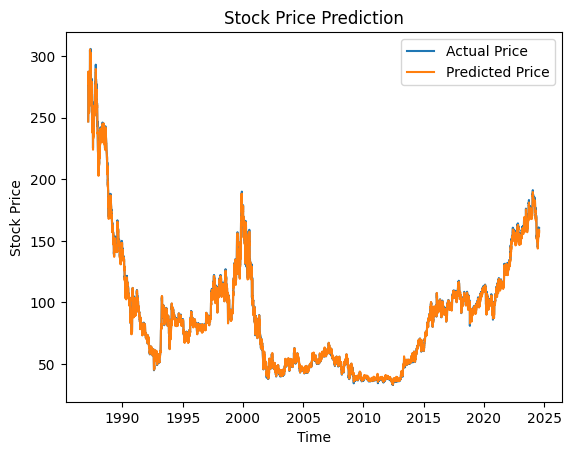

In [17]:
# ウェイトをインポートし使用するテスト
X, y = get_seq(values_scaled, 10)
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

model_path = "lstm.pth"
model = LSTMModel(input_size=6)
model.load_state_dict(torch.load(model_path))

model.eval()
with torch.no_grad():
    y_pred = model(X).numpy()
y = y.numpy()

_y_pred = np.zeros((len(y_pred), 6))
_y_pred[:, 0] = y_pred.flatten()
y_pred_inverted = scaler.inverse_transform(_y_pred)[:, 0:1]

_y = np.zeros((len(y), 6))
_y[:, 0] = y.flatten()
y_inverted = scaler.inverse_transform(_y)[:, 0:1]


dates_test = dates[-(len(y_inverted)) :, :]
plt.plot(dates_test, y_inverted, label="Actual Price")
plt.plot(dates_test, y_pred_inverted, label="Predicted Price")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.show()